# AAut lab question 1 part 1
### Linear regression with outliers

 Import libraries

# Initial steps
Load libraries, load data, visual representations

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, RANSACRegressor
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Load training data

In [73]:
# Importing the datasets
dataX = np.load('X_train.npy')
dataY = np.load('Y_train.npy')
testX = np.load('X_test.npy')

Plot the data for visual representation

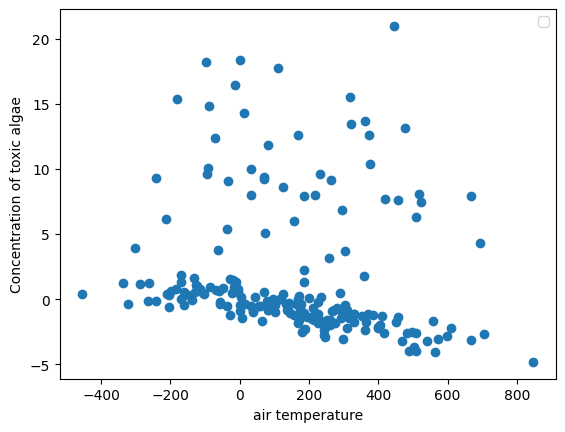

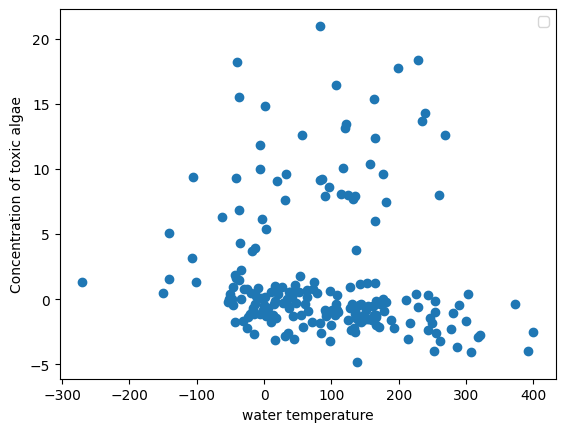

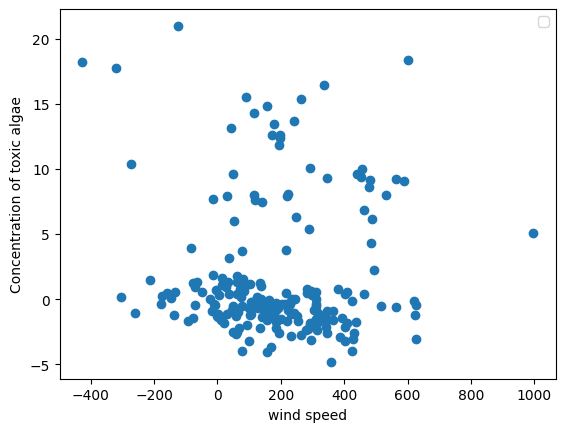

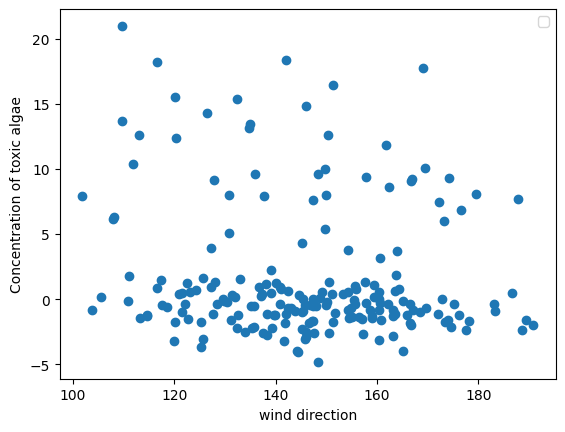

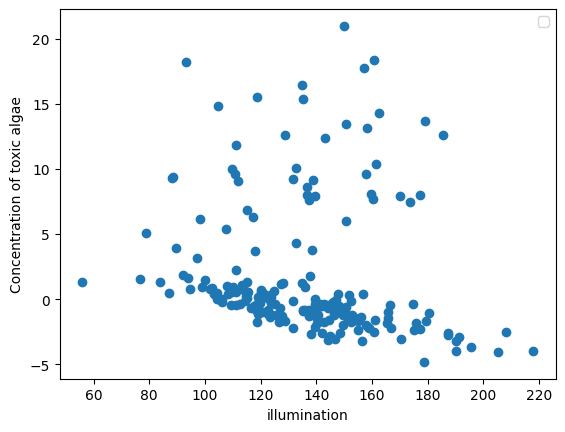

In [74]:
parameters = np.array(["air temperature", "water temperature", "wind speed", "wind direction", "illumination"])
for i in range(5):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.legend()
    plt.plot()
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")

# Important functions

Calculate SSE

In [75]:
def calculate_SSE(MSE, N):
  # Calculate the sum of squared errors
  SSE = MSE * N 
  return SSE

Create linear regression model

In [76]:
def create_model_LinearRegression(X, Y):
    # Create a linear regression model
    model = LinearRegression()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create Lasso model

In [77]:
def create_model_Lasso(X, Y):
    # Create a Lasso model
    model = LassoCV(max_iter=10000)
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create Ridge model

In [78]:
def create_model_Ridge(X, Y):
    # Create a Ridge model
    model = RidgeCV()
    # Fit the model to the data
    model.fit(X, Y)
    return model

Create RANSAC model

In [79]:
def create_model_RANSACRegressor(X, Y):
    # Create a RANSACRegressor model
    model = RANSACRegressor()
    # Fit the model to the data
    model.fit(X, Y)
    return model

## Removal of outliers

#### Predict a linear regression and remove the point with the highest mse
Comment Break and uncomment remove_outliers_x_axis to also remove outliers from x

In [80]:
def remove_outliers(X, Y):
    num_points_to_remove = int(0.25 * len(Y)) # Remove 25% of the data because of human error
    for _ in range(num_points_to_remove):
        model = LinearRegression()
        model.fit(X, Y)
        predictions = model.predict(X)

        mse = (Y - predictions) ** 2
        
        max_mse_index = np.argmax(mse)
        if mse[max_mse_index] < 1:
            break

        X = np.delete(X, max_mse_index, axis=0)
        Y = np.delete(Y, max_mse_index, axis=0)
    return X, Y

## Removal of redundant features
Predict a linear regression and see if without the feature, it performs better

In [81]:
def remove_features(X, Y):
    features_to_remove = []
    model = create_model_LinearRegression(X, Y)
    cv_score = cross_validate(model, X, Y, cv=5, scoring=('neg_mean_squared_error', 'r2'), return_train_score = True)
      
    MSE_baseline = abs(cv_score['test_neg_mean_squared_error'].mean())

    for dim in range(dataX.shape[1]):
        X_new = np.delete(X, dim, axis=1)
        model = create_model_LinearRegression(X_new, Y)
        cv_score = cross_validate(model, X_new, Y, cv=5, scoring=('neg_mean_squared_error', 'r2'), return_train_score = True)
        MSE = abs(cv_score['test_neg_mean_squared_error'].mean())
        if MSE < MSE_baseline:
            print("Removing feature", parameters[dim], "decreases the MSE from", MSE_baseline, "to", MSE)
            MSE_baseline = MSE
            features_to_remove.append(dim)
            
    new_X = np.delete(X, features_to_remove, axis=1)
    return new_X

# Experiment the models

## Remove outliers from y and x axis

In [82]:
dataX_no_outliers, dataY_no_outliers = remove_outliers(dataX, dataY)
print("Number of data points after removing outliers:", len(dataY_no_outliers))

Number of data points after removing outliers: 152


## Remove redundant features

In [83]:
dataX_removed_features = remove_features(dataX_no_outliers, dataY_no_outliers)

Removing feature wind direction decreases the MSE from 0.008037327606967085 to 0.008028784913414721
Removing feature illumination decreases the MSE from 0.008028784913414721 to 0.008004230383155855


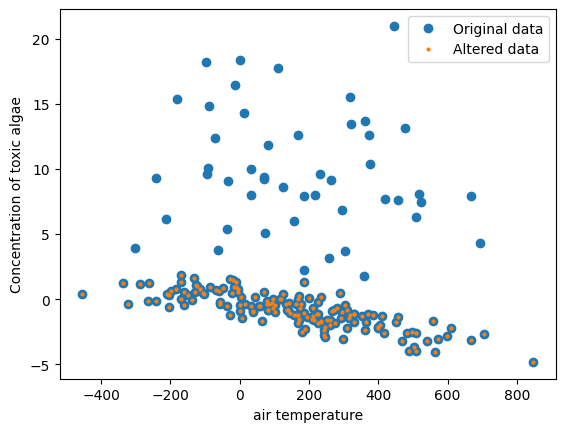

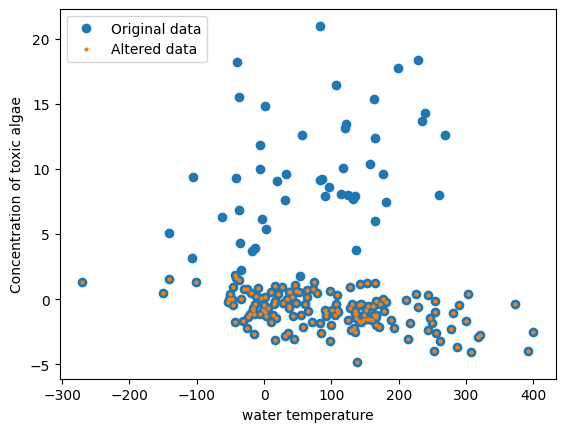

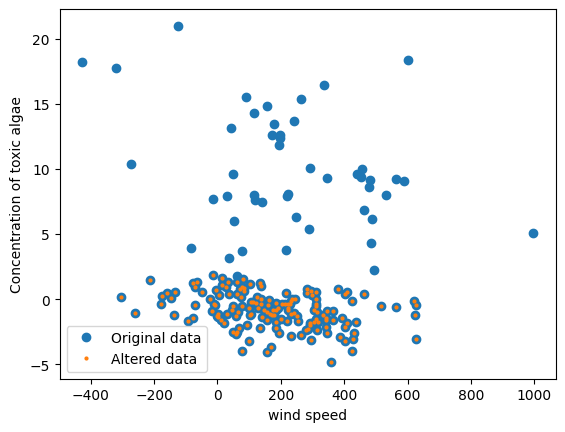

In [84]:
for i in range(dataX_removed_features.shape[1]):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(dataX_no_outliers[:,i], dataY_no_outliers, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Original data", "Altered data"])

### Create and predict
dataX_no_outliers to experiment with NO removed features
dataX_removed_features to experiment with removed features

In [85]:
# Create the models
model_LinearRegression = create_model_LinearRegression(dataX_no_outliers, dataY_no_outliers) # for final submission, best data to train on
model_Lasso = create_model_Lasso(dataX_no_outliers, dataY_no_outliers)
model_Ridge = create_model_Ridge(dataX_no_outliers, dataY_no_outliers)
model_RANSACRegressor = create_model_RANSACRegressor(dataX, dataY)

# Predict the values for the test set
predY_LinearRegression = model_LinearRegression.predict(testX) # testX for final submission
predY_Lasso = model_Lasso.predict(testX)
predY_Ridge = model_Ridge.predict(testX)
predY_RANSACRegressor = model_RANSACRegressor.predict(testX)

In [86]:
def evaluate_model(model, X, Y):    
    cv_score = cross_validate(model, X, Y, cv=5, scoring=('neg_mean_squared_error', 'r2'), return_train_score = True)
    MSE_test = abs(cv_score['test_neg_mean_squared_error'].mean())
    R2_test = cv_score['test_r2'].mean()
    MSE_train = abs(cv_score['train_neg_mean_squared_error'].mean())
    R2_train = cv_score['train_r2'].mean()
    return MSE_test, R2_test, MSE_train, R2_train

In [87]:
MSE_test, R2_test, MSE_train, R2_train = evaluate_model(model_LinearRegression, dataX_no_outliers, dataY_no_outliers)
print("Linear Regression, MSE train:", MSE_train, ", MSE test:", MSE_test, ", R2 train:", R2_train, ", R2 test:", R2_test)
MSE_test, R2_test, MSE_train, R2_train = evaluate_model(model_Lasso, dataX_no_outliers, dataY_no_outliers)
print("Lasso, MSE train:", MSE_train, ", MSE test:", MSE_test, ", R2 train:", R2_train, ", R2 test:", R2_test)
MSE_test, R2_test, MSE_train, R2_train = evaluate_model(model_Ridge, dataX_no_outliers, dataY_no_outliers)
print("Ridge, MSE train:", MSE_train, ", MSE test:", MSE_test, ", R2 train:", R2_train, ", R2 test:", R2_test)
MSE_test, R2_test, MSE_train, R2_train = evaluate_model(model_RANSACRegressor, dataX_no_outliers, dataY_no_outliers)
print("RANSACRegressor, MSE train:", MSE_train, ", MSE test:", MSE_test, ", R2 train:", R2_train, ", R2 test:", R2_test)

Linear Regression, MSE train: 0.0074213297169221995 , MSE test: 0.008037327606967085 , R2 train: 0.9957067686212587 , R2 test: 0.9948613363086223
Lasso, MSE train: 0.007536968711220301 , MSE test: 0.008006721567689622 , R2 train: 0.9956399221248755 , R2 test: 0.9948796455021067
Ridge, MSE train: 0.007421496325162469 , MSE test: 0.008031127904195136 , R2 train: 0.9957066721790243 , R2 test: 0.9948648443302673
RANSACRegressor, MSE train: 0.007515835266007818 , MSE test: 0.00786307723906456 , R2 train: 0.9956518837868632 , R2 test: 0.9949614076722286


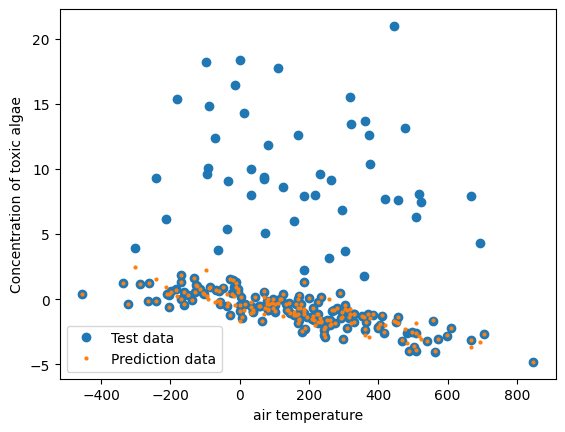

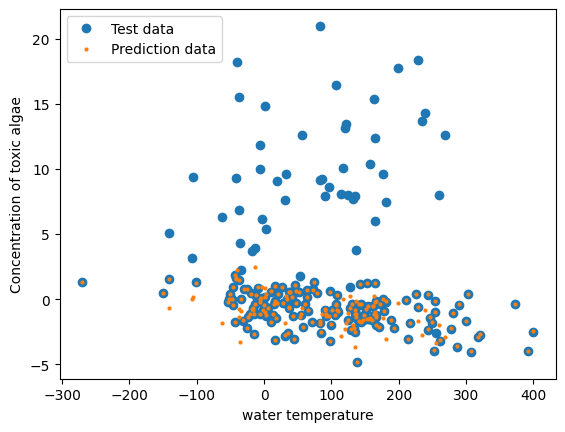

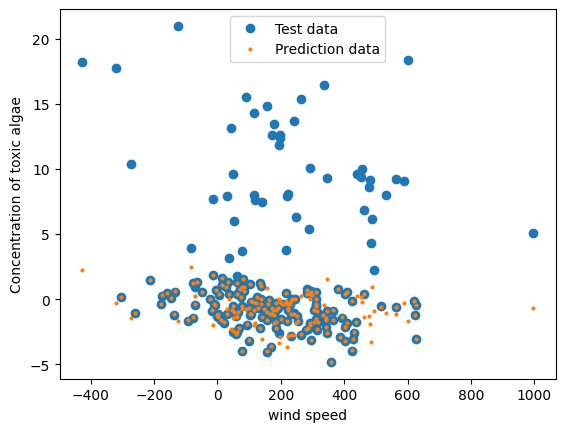

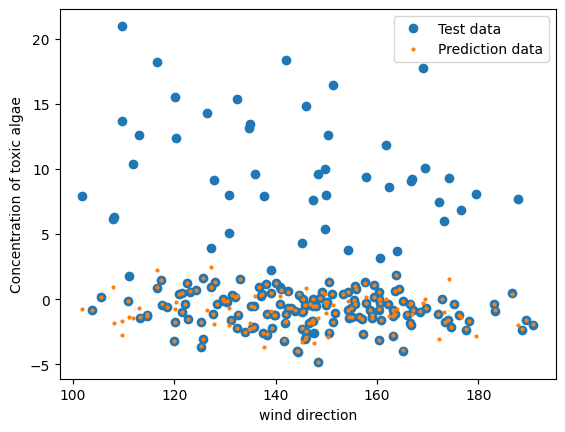

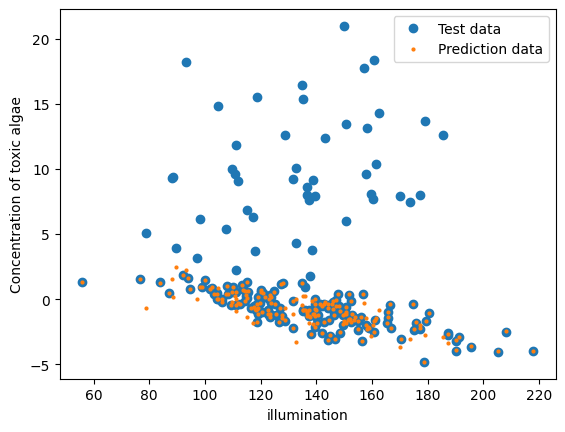

In [88]:
for i in range(dataX_no_outliers.shape[1]):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(testX[:,i], predY_Ridge, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Test data", "Prediction data"])